# Task 6: Individual Root Segmentation

The goal for this task is to perform instance segmentation at the root level, aiming to separate each individual root within the masks.


In [17]:
# Import necessary modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

The final logic for solving this task has been based on multiple assumptions:
- There are always 5 plants in the image (even if germination has not started yet)
- A plant is considered to have an area of min 250 pixels
- A plant's area is: h = 1.5 x w
- Components that start too low in the image are ignored

The solution works by first identifying all groups of connected white pixels in a binary mask, with each group considered a potential object. The script then applies a series of filtering criteria to these components to ensure that only valid plants are kept. It discards components that are too small (min_area), not tall enough relative to their width (aspect_ratio_threshold), or located too low in the image (vertical_start_thresh_ratio). After filtering, the script spatially assigns each valid component to one of five vertical "bands" based on its horizontal position (centroid), assuming there are five plants. Finally, it creates and visualizes a separate binary mask for each plant, effectively achieving instance segmentation by isolating each plant's root structure into its own image.

## Step 1: Load raw prediction

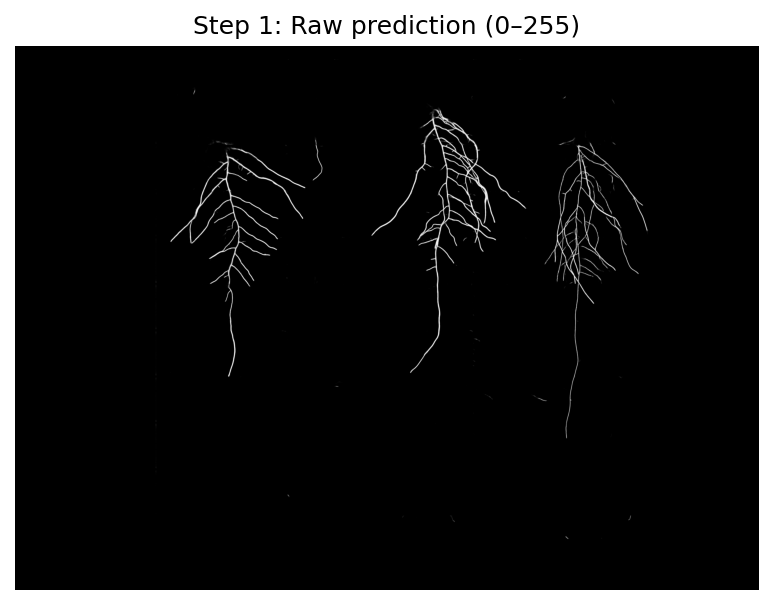

In [18]:
# Load the raw predicted mask from inference notebook task 5 (grayscale: 0–255)
raw_path = r"C:\BUAS\retake\2024-25b-fai2-adsai-dariavladutu236578\datalab_tasks\task5\task5_test_image_prediction_daria_236578.png"
raw_loaded = cv2.imread(raw_path, cv2.IMREAD_GRAYSCALE)

plt.figure(dpi=150)
plt.imshow(raw_loaded, cmap='gray')
plt.title('Step 1: Raw prediction (0–255)')
plt.axis('off')
plt.show()

## Step 2: Threshold the prediction

Here we convert the raw prediction into a clean binary mask by setting the threshold that controls the stictness of what is considered part of the root system and what is not (1 - root system, 0 - others). We then perform binarisation by converting the fraction 0.1 into the 0-255 range, helping to eliminate low-confidence predicyions and retaining only the regions where the model is confident about root presence.


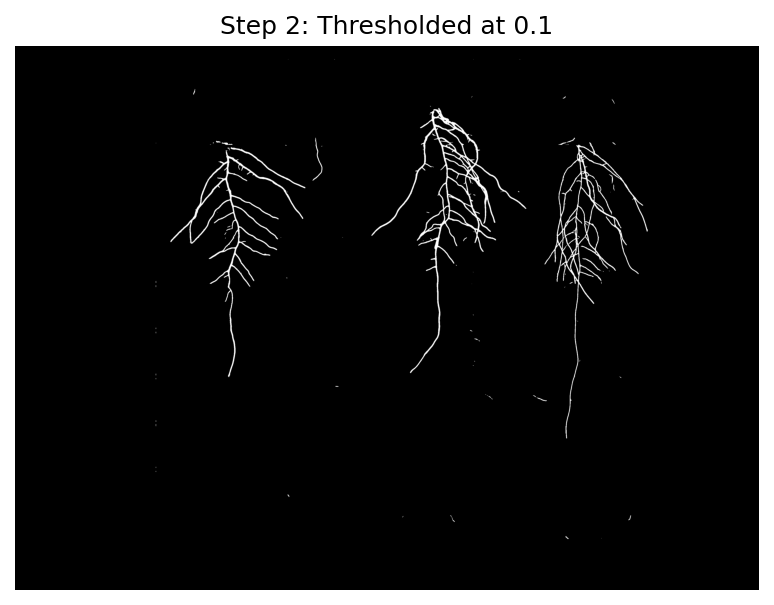

In [19]:
# Threshold the raw prediction 
threshold = 0.1
binaclosed_croppedry = (raw_loaded > int(threshold * 255)).astype(np.uint8)

plt.figure(dpi=150)
plt.imshow(binary * 255, cmap='gray')
plt.title(f'Step 2: Thresholded at {threshold}')
plt.axis('off')
plt.show()

## Step 3: Morphological closing

After thresholding, some roots may still appear broken or fragmented due to small gaps in the prediction. To address this, we apply morphological closing (dilation followed by erosion). 

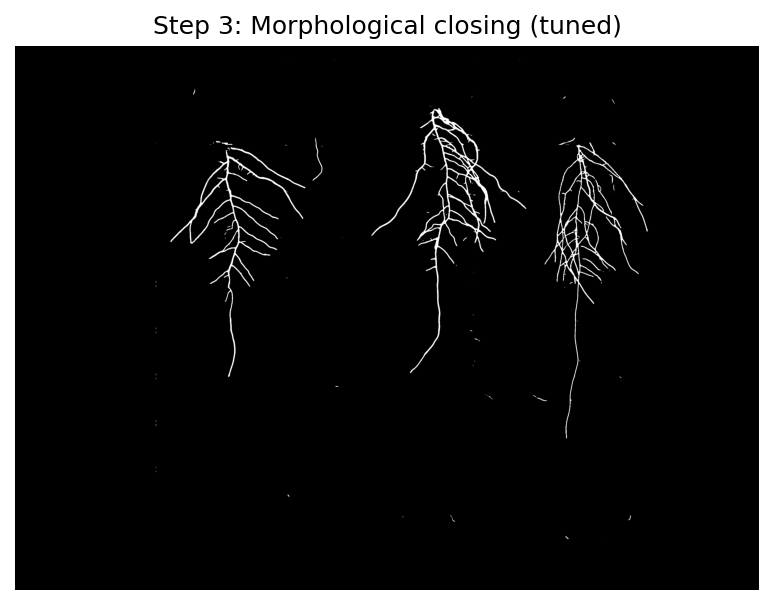

In [20]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 3))  

# Apply closing multiple times (this was decided after experimentation)
closed = binary.copy()
for _ in range(3):
    closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel)

plt.figure(dpi=150)
plt.imshow(closed * 255, cmap='gray')
plt.title('Step 3: Morphological closing (tuned)')
plt.axis('off')
plt.show()

## Step 4: Crop the mask

Since we are only concerntrating on the middle-ish portion of the mask (where the root data is), we will crop the mask and work with it in such manner. The horizontal margins are empty, and therefore can interfere with other processing steps.

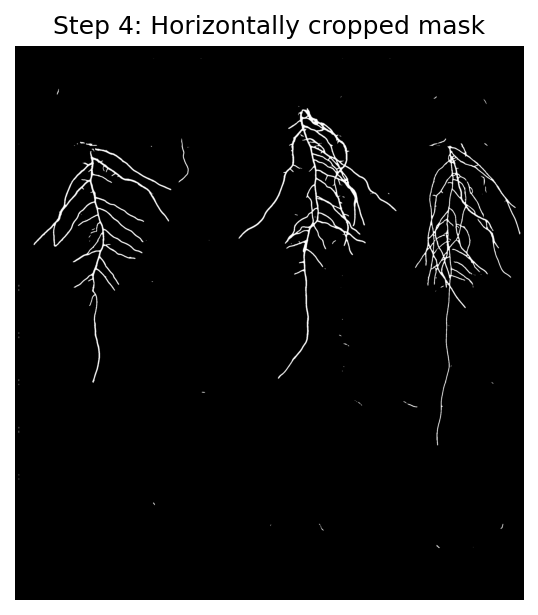

In [21]:
# Crop horizontally to remove empty sides
def crop_horizontal_mask_region(mask, margin=20):
    col_sums = np.sum(mask, axis=0)
    cols = np.where(col_sums > 0)[0]

    if len(cols) == 0:
        return mask, (0, 0)  # No content

    left_crop = max(cols[0] - margin, 0)
    right_crop = max(mask.shape[1] - cols[-1] - 1 - margin, 0)

    cropped = mask[:, left_crop:mask.shape[1] - right_crop]
    return cropped, (left_crop, right_crop)

closed_cropped, (left_crop, right_crop) = crop_horizontal_mask_region(closed)

# Visualize cropped mask
plt.figure(dpi=150)
plt.imshow(closed_cropped * 255, cmap='gray')
plt.title('Step 4: Horizontally cropped mask')
plt.axis('off')
plt.show()

## Step 5: Crop the top of the mask

Here we segment the top-cropped mask into individual plant root masks by first detecting all connected components and then assigning them to one of five vertical bands based on the x-coordinate of their centroid.

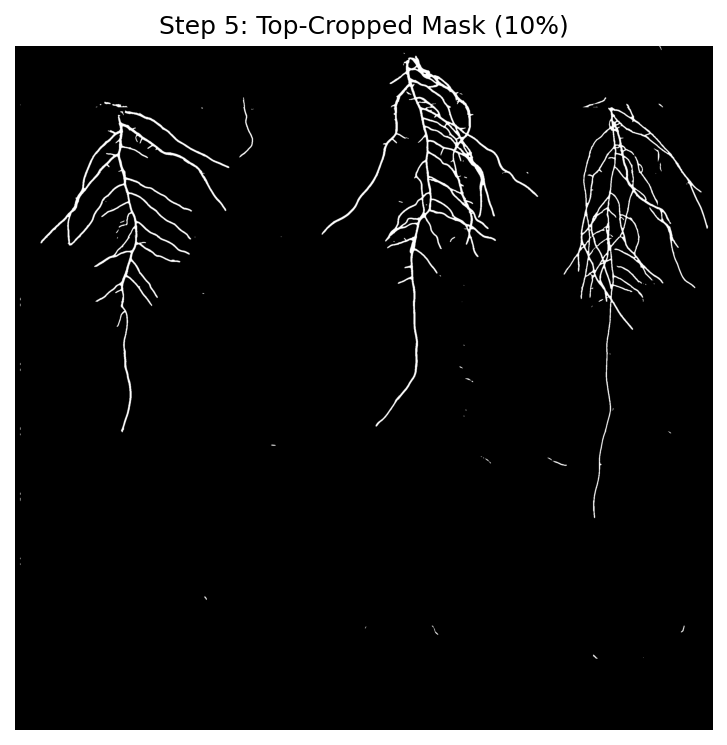

In [22]:
top_crop_ratio = 0.1  # Crop top 10% of the image

h, w = closed_cropped.shape
top_crop = int(h * top_crop_ratio)
top_cropped_mask = closed_cropped[top_crop:, :]

# Visualize the cropped mask
plt.figure(figsize=(6, 6), dpi=150)
plt.imshow(top_cropped_mask * 255, cmap='gray')
plt.title("Step 5: Top-Cropped Mask (10%)")
plt.axis('off')
plt.show()


## Step 6: Final segmentation

All the steps that have been implemented here are described in detail at the beginning of the notebook.

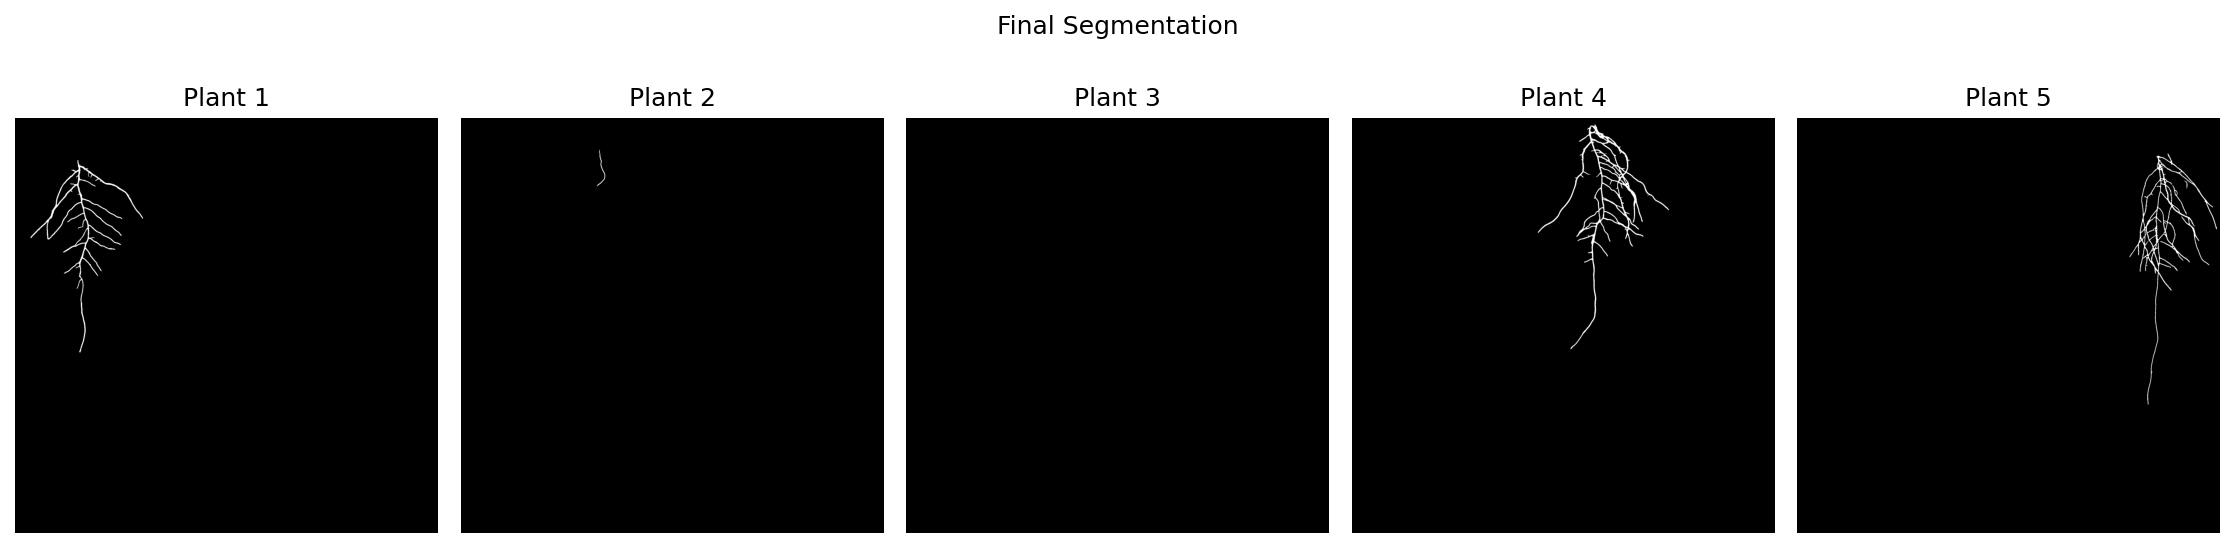

In [23]:
num_plants = 5
min_area = 250
aspect_ratio_threshold = 1.5  # height must be at least 1.5x width
vertical_start_thresh_ratio = 0.3  # filter components that start too low

# Connected components on full top-cropped mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(top_cropped_mask)

h, w = top_cropped_mask.shape
band_width = w / num_plants

# Initialize empty masks (1 per plant)
final_masks = [np.zeros_like(top_cropped_mask, dtype=np.uint8) for _ in range(num_plants)]

for i in range(1, num_labels):  # skip background
    x, y, cw, ch, area = stats[i]
    cx = centroids[i][0]

    if area < min_area:
        continue

    aspect_ratio = ch / cw if cw > 0 else 0
    if aspect_ratio < aspect_ratio_threshold:
        continue

    if y > int(h * vertical_start_thresh_ratio):
        continue

    band_idx = int(cx // band_width)
    band_idx = min(band_idx, num_plants - 1)

    component_mask = (labels == i).astype(np.uint8)
    final_masks[band_idx] = np.logical_or(final_masks[band_idx], component_mask).astype(np.uint8)

# Visualize result
plt.figure(figsize=(15, 4), dpi=150)
for i in range(num_plants):
    plt.subplot(1, num_plants, i + 1)
    plt.imshow(final_masks[i] * 255, cmap='gray')
    plt.title(f'Plant {i + 1}')
    plt.axis('off')
plt.suptitle("Final Segmentation", fontsize=12)
plt.tight_layout()
plt.show()

## Step 9: Save components!

In [24]:
import os

save_dir = r"components"

# Ensure the save directory exists
os.makedirs(save_dir, exist_ok=True)

# Save each root mask
for i, mask in enumerate(final_masks):
    filename = os.path.join(save_dir, f"plant_{i + 1}.png")
    cv2.imwrite(filename, mask)
    print(f"Saved: {filename}")


Saved: components\plant_1.png
Saved: components\plant_2.png
Saved: components\plant_3.png
Saved: components\plant_4.png
Saved: components\plant_5.png
